# Active Kriging-Monte Carlo Simulation Example 2
Author: Mohit S. Chauhan Date: Oct 14, 2019

In this example, Stratified sampling is used to generate samples from Uniform distribution and new samples are generated adaptively, using 'EFF'(Expected Feasibilty Function) as the learning criteria .

Import the necessary libraries. Here we import standard libraries such as numpy, matplotlib and other necessary library for plots, but also need to import the MCS, STS and AKMCS class from UQpy.

In [1]:
from UQpy.SampleMethods import MCS
from UQpy.SampleMethods import STS
from UQpy.SampleMethods import AKMCS
from UQpy.Surrogates import Krig
from UQpy.RunModel import RunModel
from Mod_Rastrigin import rastrigin
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern
import numpy as np
import scipy.stats as sp
import time

Using UQpy STS class to generate samples for two random variables, which are normally distributed with mean 0 and variance 1.

In [2]:
np.random.seed(2)
x = STS(dist_name=['Normal']*2, dist_params=[[0, 1.5], [0, 1.5]], sts_design=[10, 10])

UQpy: Successful execution of STS design..


RunModel class is used to define an object to evaluate the model at sample points.

In [3]:
rmodel = RunModel(model_script='Mod_Rastrigin.py')

A regression model is defined, this function return the basis function and its jacobian.

In [4]:
def quadratic_sin(s):
    s = np.atleast_2d(s)
    fx = np.concatenate((np.ones([np.size(s, 0), 1]), s**2, np.sin(s)), 1)
    jfb1 = np.zeros([np.size(s, 0), np.size(s, 1), np.size(s, 1)])
    np.einsum('jii->ji', jfb1)[:] = np.cos(s)
    jfb2 = np.zeros([np.size(s, 0), np.size(s, 1), np.size(s, 1)])
    np.einsum('jii->ji', jfb2)[:] = 2*s
    jf = np.concatenate((np.zeros([np.size(s, 0), np.size(s, 1), 1]), jfb2, jfb1), 2)
    return fx, jf

Krig class defines an object to generate an surrogate model for a given set of data.

In [5]:
K = Krig(reg_model=quadratic_sin, corr_model='Gaussian', n_opt=15, dimension=2)

In [6]:
k = Matern(10*np.ones([2, 1]), [[1e-2, 1e5]]*2, nu=0.5)

AKMCS class is used to generate new sample using 'EFF'(Expected Feasibilty Function) as active learning function.

In [7]:
%%capture
start_time = time.time()
a = AKMCS(run_model_object=rmodel, sample_object=x, krig_object=K, nlearn=10**4, n_add=1, 
          lf='EFF', min_cov=0.05, kriging='UQpy')
a.run(nsamples=200)
elapsed_time = time.time() - start_time

In [8]:
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Time: ', elapsed_time)
print('Function evaluation: ', a.sample_object.samples.shape[0])
print('Probability of failure: ', a.pf, '  ', 'Covariance: ', a.cov_pf)

Time:  48.28927206993103
Function evaluation:  200
Probability of failure:  0.201980198019802    Covariance:  0.019778427071970955


This figure shows the location of new samples generated using active learning function.

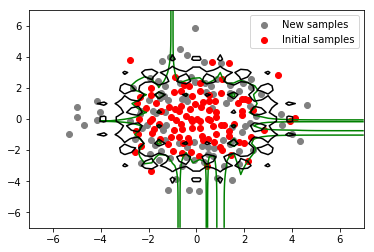

In [9]:
num = 50
x1 = np.linspace(-7, 7, num)
x2 = np.linspace(-7, 7, num)
x1v, x2v = np.meshgrid(x1, x2)
y = np.zeros([num, num])
y_act = np.zeros([num, num])
mse = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        xa = x.distribution[0].cdf(np.atleast_2d(x1v[i, j]), x.dist_params[0])
        ya = x.distribution[1].cdf(np.atleast_2d(x2v[i, j]), x.dist_params[1])
        y[i, j] = a.krig_model(np.hstack([xa, ya]))
        y_act[i, j] = rastrigin(np.array([x1v[i, j], x2v[i, j]]))

fig, ax = plt.subplots()
# ax = plt.axes(projection='3d')
# Plot for estimated values
kr = ax.contour(x1v, x2v, y, levels=[0], colors='Green')
# kr.cmap.set_over('green')
kr_a = ax.contour(x1v, x2v, y_act, levels=[0], colors='Black')


# Plot for scattered data
nd = np.prod(x.sts_design)
ID1 = ax.scatter(a.sample_object.samples[nd:, 0], a.sample_object.samples[nd:, 1], color='Grey', label='New samples')
ID = ax.scatter(x.samples[:nd, 0], x.samples[:nd, 1], color='Red', label='Initial samples')
plt.legend(handles=[ID1, ID])
plt.show()

Probability of failure and covariance is estimated using Monte Carlo Simulation.

In [10]:
start_time = time.time()

# Code
b = MCS(dist_name=x.dist_name, dist_params=x.dist_params, nsamples=10**5)
r1model = RunModel(model_script='Mod_Rastrigin.py')
r1model.run(samples=b.samples)
gx = np.array(r1model.qoi_list)
pf_mcs = np.sum(np.array(gx) < 0)/b.nsamples
cov_pf_mcs = np.sqrt((1 - pf_mcs)/(pf_mcs * b.nsamples))

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'00:00:01'

Results from Monte Carlo Simulation.

In [11]:
print('Time: ', elapsed_time)
print('Function evaluation: ', b.nsamples)
print('Probability of failure: ', pf_mcs, '  ', 'Covariance: ', cov_pf_mcs)

Time:  1.8425788879394531
Function evaluation:  100000
Probability of failure:  0.19133    Covariance:  0.006501209034861414
